# Diabetes Prediction Project

This notebook takes a baseline diabetes prediction model and improves it with:
1.  **Advanced EDA:** Visualizations to understand the data.
2.  **Data Cleaning:** Handling impossible '0' values.
3.  **No Data Leakage:** Correctly applying imputation and scaling *after* the train/test split.
4.  **Hyperparameter Tuning:** Using `GridSearchCV` to find the best model parameters.
5.  **Robust Evaluation:** Using a Classification Report and Confusion Matrix.
6.  **Model Persistence:** Saving the final model and preprocessors (`scaler`, `imputer medians`) for future use.

## 1. Importing Dependencies

We'll add `matplotlib`, `seaborn` for plotting, and more `sklearn` modules for evaluation and tuning.

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings

warnings.filterwarnings('ignore')

## 2. Data Collection and Advanced EDA

In [174]:
# loading the diabetes dataset to a pandas DataFrame
diabetes_dataset = pd.read_csv('data/diabetes.csv')

In [175]:
# First 5 rows
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [176]:
# Dataset shape
print(diabetes_dataset.shape)

(768, 9)


In [177]:
# Statistical measures
diabetes_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### EDA: Visualizing the Data

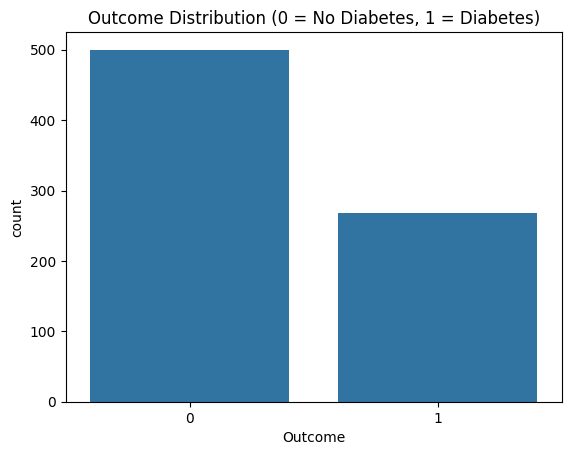

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [178]:
# Check the balance of the 'Outcome' variable
sns.countplot(x='Outcome', data=diabetes_dataset)
plt.title('Outcome Distribution (0 = No Diabetes, 1 = Diabetes)')
plt.show()

print(diabetes_dataset['Outcome'].value_counts(normalize=True))

> **Observation:** The dataset is somewhat imbalanced (~65% non-diabetic, 35% diabetic). This is why 'accuracy' alone isn't a good metric. We must also check precision and recall.

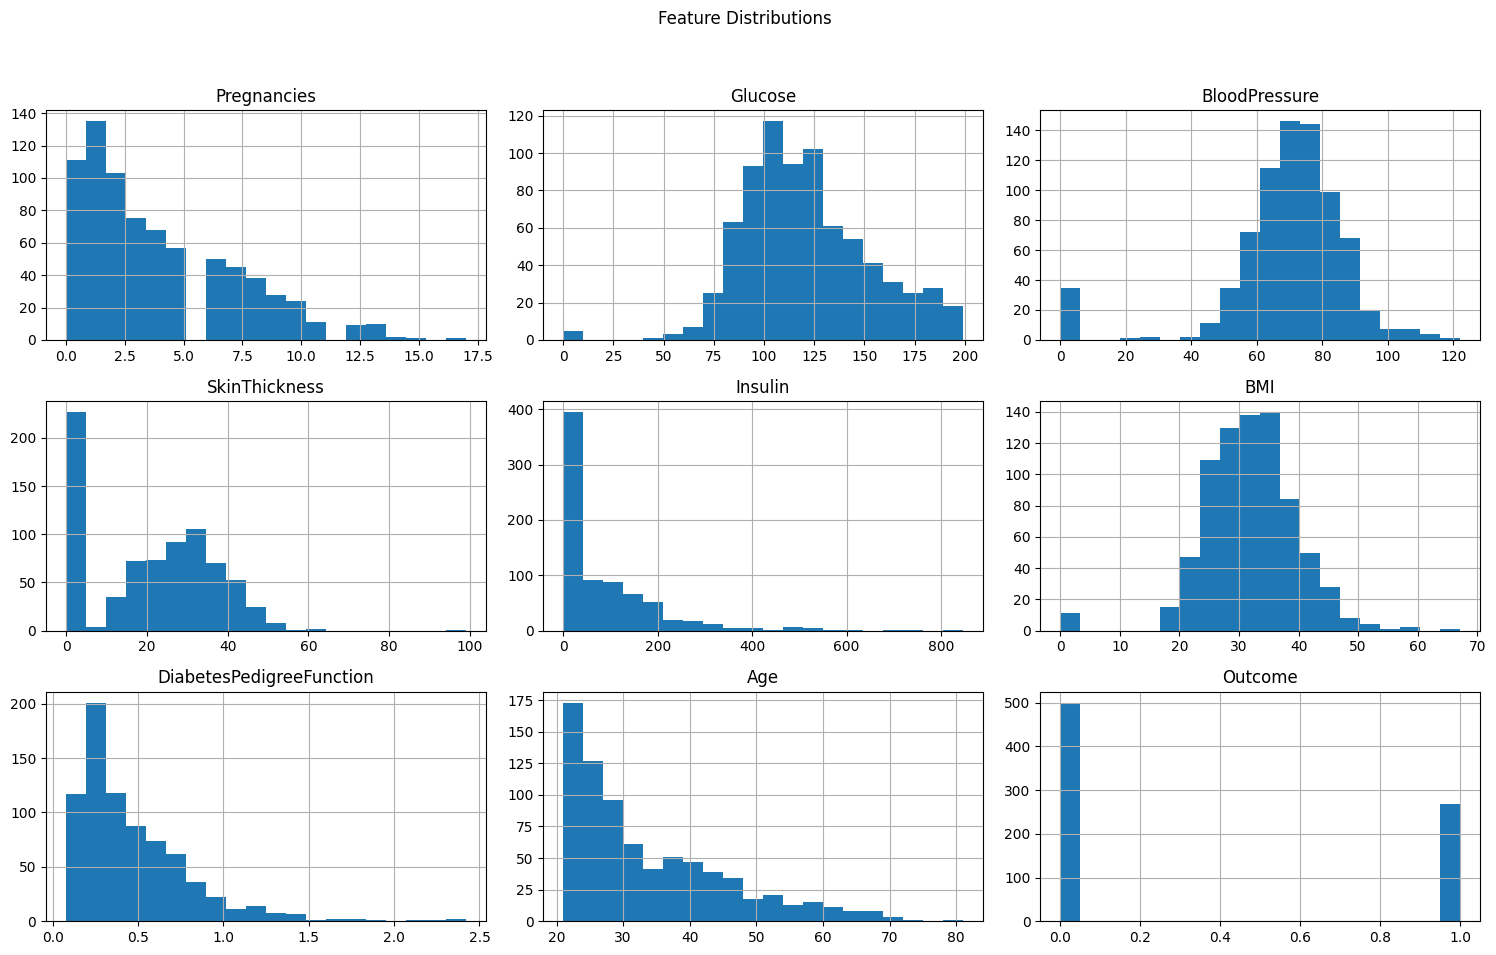

In [166]:
# Plot distributions for all features
diabetes_dataset.hist(bins=20, figsize=(15, 10))
plt.suptitle('Feature Distributions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()

> **Observation (Critical):** `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` have a large number of '0' values. These are biologically impossible and are clearly missing data.

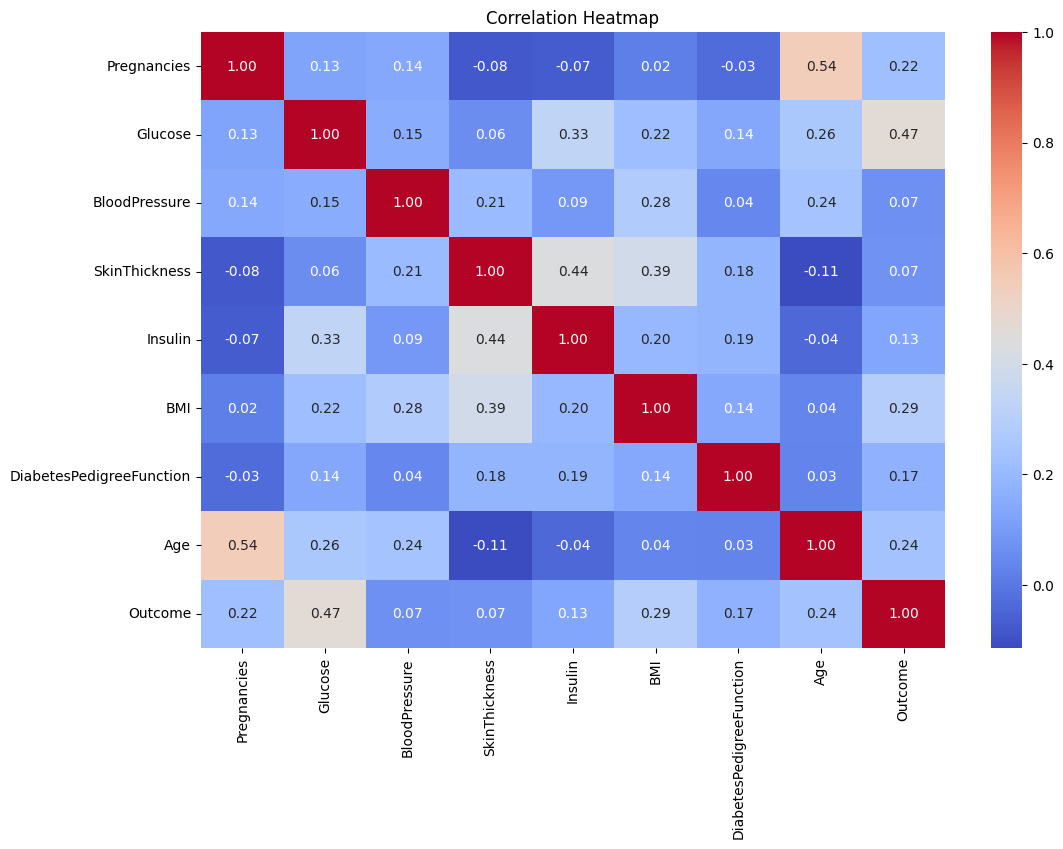

In [167]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(diabetes_dataset.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

> **Observation:** `Glucose` has the highest correlation with `Outcome`, which makes sense. `Age`, `BMI`, and `Pregnancies` also show a notable correlation.

## 3. Data Preprocessing (The *Correct* Way)

Here is the proper, leakage-free workflow:
1.  Separate `X` (features) and `Y` (labels).
2.  Split into `X_train`, `X_test`, `Y_train`, `Y_test`.
3.  **Handle 0s:** Replace 0s with `np.nan` in both `X_train` and `X_test`.
4.  **Impute NaNs:** Calculate the median *only* from `X_train`, then use that median to fill NaNs in *both* `X_train` and `X_test`.
5.  **Scale Data:** Create `StandardScaler`, `fit` it *only* on `X_train`, and then `transform` *both* `X_train` and `X_test`.

In [168]:
# 1. Separate X and Y
X = diabetes_dataset.drop(columns = 'Outcome', axis=1)
Y = diabetes_dataset['Outcome']

In [169]:
# 2. Split into Train and Test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

In [170]:
# 3. Handle 0s: Replace with NaN
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# We use .copy() to avoid SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()

X_train[cols_with_zeros] = X_train[cols_with_zeros].replace(0, np.nan)
X_test[cols_with_zeros] = X_test[cols_with_zeros].replace(0, np.nan)

In [171]:
# 4. Impute NaNs using the median from X_train
impute_medians = X_train.median()
print("Medians calculated from training data:")
print(impute_medians)

X_train = X_train.fillna(impute_medians)
X_test = X_test.fillna(impute_medians)

print("\nNaNs in X_train after imputation:", X_train.isnull().sum().sum())
print("NaNs in X_test after imputation:", X_test.isnull().sum().sum())

Medians calculated from training data:
Pregnancies                   3.000
Glucose                     117.000
BloodPressure                72.000
SkinThickness                29.000
Insulin                     123.500
BMI                          32.400
DiabetesPedigreeFunction      0.367
Age                          29.000
dtype: float64

NaNs in X_train after imputation: 0
NaNs in X_test after imputation: 0


In [172]:
# 5. Scale Data (Fit on Train, Transform Train and Test)
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train)

# Transform both training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Note: X_train_scaled and X_test_scaled are now numpy arrays
print(X_train_scaled[0])

[-1.13796489 -0.10144145 -0.06381849 -0.02716275 -0.19414261 -0.0357425
 -0.98159708 -0.7885233 ]


## 4. Model Training & Hyperparameter Tuning

Instead of just one model, we'll use `GridSearchCV` to find the best `SVC` parameters.

In [179]:
classifier = svm.SVC()

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'], # Kernel type
    'gamma': ['scale', 'auto', 0.1, 1] # Kernel coefficient for 'rbf'
}

# We use 'f1_weighted' as the score because the classes are imbalanced
# cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(estimator=classifier, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='f1_weighted', 
                           verbose=2, 
                           n_jobs=-1) # Use all available CPU cores

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled, Y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s

[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, 

,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'gamma': ['scale', 'auto', ...], 'kernel': ['linear', 'rbf']}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


In [180]:
# Get the best parameters and the best model
print("Best Parameters found:", grid_search.best_params_)
print("Best F1-score on validation data:", grid_search.best_score_)

# The best_model is the classifier already trained on the full (scaled) training data
best_model = grid_search.best_estimator_

Best Parameters found: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best F1-score on validation data: 0.7605230507026399


## 5. Comprehensive Model Evaluation

In [181]:
# Evaluate the best_model on the (unseen) test data
Y_pred = best_model.predict(X_test_scaled)

print("--- Test Data Evaluation ---")
print(f"Accuracy Score: {accuracy_score(Y_test, Y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(Y_test, Y_pred, target_names=['Non-Diabetic (0)', 'Diabetic (1)']))

--- Test Data Evaluation ---
Accuracy Score: 0.7597

Classification Report:
                  precision    recall  f1-score   support

Non-Diabetic (0)       0.76      0.93      0.83       100
    Diabetic (1)       0.77      0.44      0.56        54

        accuracy                           0.76       154
       macro avg       0.77      0.69      0.70       154
    weighted avg       0.76      0.76      0.74       154



> **How to Read this Report:**
> * **Precision:** Of all the people we *predicted* as Diabetic, what percentage *actually* were? (High precision = fewer False Positives).
> * **Recall:** Of all the people who *are actually* Diabetic, what percentage did we *correctly identify*? (High recall = fewer False Negatives).
> * **F1-Score:** The harmonic mean of Precision and Recall. A good all-in-one metric.

In a medical test, you often care more about **Recall** for the positive class (Diabetic (1)) – you want to find as many sick people as possible, even if it means you get a few false positives.

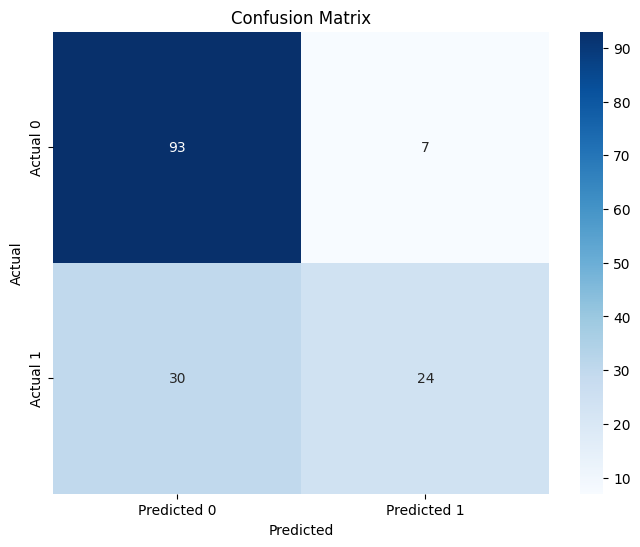

In [182]:
# Visualize the Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

> **How to Read this Matrix:**
> * **Top-Left (True Negative):** Correctly predicted 'Non-Diabetic'.
> * **Bottom-Right (True Positive):** Correctly predicted 'Diabetic'.
> * **Top-Right (False Positive):** Incorrectly predicted 'Diabetic' (Type I Error).
> * **Bottom-Left (False Negative):** Incorrectly predicted 'Non-Diabetic' (Type II Error) - **This is often the most dangerous error in medical diagnosis.**

## 6. Saving the Model & Preprocessors

For a real application, you must save:
1.  The trained `best_model`.
2.  The fitted `scaler`.
3.  The `impute_medians`.

In [183]:
joblib.dump(best_model, 'diabetes_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(impute_medians, 'impute_medians.joblib')

print("Model, scaler, and imputation values saved successfully!")

Model, scaler, and imputation values saved successfully!


## 7. Making a Predictive System (The *Right* Way)

Now, we'll create a function that mimics a real-world prediction, loading the saved files and processing new, raw input data.

In [184]:
# Load the saved files
try:
    loaded_model = joblib.load('diabetes_model.joblib')
    loaded_scaler = joblib.load('scaler.joblib')
    loaded_medians = joblib.load('impute_medians.joblib')
    print("Files loaded for prediction.")
except FileNotFoundError:
    print("Error: Model files not found. Please run section 6 first.")

Files loaded for prediction.


In [185]:
def predict_diabetes(input_data_tuple):
    """
    Takes raw input data as a tuple, preprocesses it exactly
    as the training data, and returns a prediction.
    """
    # Get the feature names in the correct order
    feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

    # 1. Convert tuple to a pandas DataFrame with correct column names
    input_df = pd.DataFrame([input_data_tuple], columns=feature_names)

    # 2. Handle '0' values by replacing them with NaN
    input_df[cols_with_zeros] = input_df[cols_with_zeros].replace(0, np.nan)
    
    # 3. Impute NaNs using the *saved* medians from the training data
    input_df = input_df.fillna(loaded_medians)
    
    # 4. Scale the data using the *saved* scaler
    input_data_scaled = loaded_scaler.transform(input_df)
    
    # 5. Make prediction
    prediction = loaded_model.predict(input_data_scaled)
    
    return prediction[0]



In [186]:
# Example 1: Data from the original notebook (is Diabetic)
input_data_1 = (5, 166, 72, 19, 175, 25.8, 0.587, 51)
prediction_1 = predict_diabetes(input_data_1)

if (prediction_1 == 0):
  print(f"Prediction 1: The person is NOT diabetic (Outcome: {prediction_1})")
else:
  print(f"Prediction 1: The person IS diabetic (Outcome: {prediction_1})")

# Example 2: Data for a likely non-diabetic person
# (Pregnancies=1, Glucose=85, BP=66, SkinThickness=29, Insulin=0, BMI=26.6, DPF=0.351, Age=31) 
# Note: The '0' for Insulin will be correctly imputed.
input_data_2 = (1, 85, 66, 29, 0, 26.6, 0.351, 31)
prediction_2 = predict_diabetes(input_data_2)

if (prediction_2 == 0):
  print(f"Prediction 2: The person is NOT diabetic (Outcome: {prediction_2})")
else:
  print(f"Prediction 2: The person IS diabetic (Outcome: {prediction_2})")

Prediction 1: The person IS diabetic (Outcome: 1)
Prediction 2: The person is NOT diabetic (Outcome: 0)
